In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set()

C_ATC = [0 ,10 ,20,40 ,60 ,80 ,100 ,150 ,250 ,500 ,750,1000]

In [2]:
def fold_change(lkns, el, gama,c, K=1):
    
    pref= 1/lkns -1
    numeratorfc = 1+np.exp(-el-gama)*((c/K)**2)
    denomenatorfc = 1+np.exp(-el)*((c/K)**2)
    
    FC = 1/(1+pref*numeratorfc/denomenatorfc)
    return FC

In [3]:
FCs_read = []
with open('FCdata_new.txt','r') as g: fclines=g.readlines()[0].split('$')[1:-1]
for each in fclines:
    tempfc=[]
    for eac in each[2:-2].split('], ['):
        tpfc=[float(ea) for ea in eac.split(',')]
        tempfc.append(tpfc)
    FCs_read.append(tempfc)
print(len(FCs_read))

23


In [5]:
# experimental leakiness of each mutant and the corresponding sem
with open('leak_info.txt','r') as g:
    alllines=g.readlines()[0][2:-2]
    
temp_leakraw, Leakns_info =alllines.split('], ['), []
for each in temp_leakraw:
    tplkr, templ =each.split(','), []
    for eac in tplkr: templ.append(float(eac))
    Leakns_info.append(templ)
print(np.shape(Leakns_info))

(23, 2)


In [6]:
# the inferred 1000 posterior samples (el,gama,sigma) for each mutant, taken from 1 million MC samples
with open('Inferred_Post_Samples.txt','r') as f: 
    alllines=f.readlines()
Post_Samples=[]
for each in alllines[2::2]:
    Temp=[]
    for eac in each[2:-3].split('], ['):
        temp=[float(ea) for ea in eac.split(',')]
        Temp.append(temp)
    Post_Samples.append(Temp[1:1001])
print(np.shape(Post_Samples))

(23, 1000, 3)


In [7]:
def goodness_of_fit(lkns,paraminfered_mutant,DATA4,name,limyh=1.2,limyl=-0.2, yticks=np.arange(-0.2,1.21,0.2),ylabelpad=None):
    mc_step=len(paraminfered_mutant)
    
    Us=[] # 4001*12 4001 sets of params, 12 expectation for 12concentrations for each set of param
    for each in paraminfered_mutant:
        tempu=[]
        for c in C_ATC:
            tempu.append(fold_change(lkns,each[0],each[1],c))
        Us.append(tempu)
    ## for each set of params, generate 48 fold changes
    predict_fc=[]
    for i in range(mc_step):
        temp12=[]
        for j in range(12):
            temp=[]
            for k in range(4):
                temp.append(np.random.normal(Us[i][j],paraminfered_mutant[i][2]))
            temp12.append(temp)
        predict_fc.append(temp12)
    
    fc_predict_12=[]
    for m in range(12):
        tempm=[]
        for n in range(mc_step):
            for each in predict_fc[n][m]:
                tempm.append(each)
        fc_predict_12.append(np.sort(tempm))
    
    # next, plot the predictive fold change from the infered 4001 sets of param
    fc_median=[]
    fc_up5,fc_low5=[],[]
    fc_up10,fc_low10=[],[]
    fc_up20,fc_low20=[],[]
    fc_up50,fc_low50=[],[]
    fc_up80,fc_low80=[],[]
    fc_up95,fc_low95=[],[]
    fc_up99,fc_low99=[],[]
    
    mc_step*=4
#     print(mc_step)
    
    for i in range(12):
        fc_median.append(np.median(fc_predict_12[i]))
        fc_up5.append(fc_predict_12[i][round(mc_step*0.95/2)])
        fc_low5.append(fc_predict_12[i][-round(mc_step*0.95/2)])
        fc_up10.append(fc_predict_12[i][round(mc_step*0.9/2)])
        fc_low10.append(fc_predict_12[i][-round(mc_step*0.9/2)])
        fc_up20.append(fc_predict_12[i][round(mc_step*0.8/2)])
        fc_low20.append(fc_predict_12[i][-round(mc_step*0.8/2)])
        fc_up50.append(fc_predict_12[i][round(mc_step*0.5/2)])
        fc_low50.append(fc_predict_12[i][-round(mc_step*0.5/2)])
        fc_up80.append(fc_predict_12[i][round(mc_step*0.2/2)])
        fc_low80.append(fc_predict_12[i][-round(mc_step*0.2/2)])
        fc_up95.append(fc_predict_12[i][round(mc_step*0.05/2)])
        fc_low95.append(fc_predict_12[i][-round(mc_step*0.05/2)])
        fc_up99.append(fc_predict_12[i][round(mc_step*0.01/2)])
        fc_low99.append(fc_predict_12[i][-round(mc_step*0.01/2)])
    FC_pred_plot = plt.figure(figsize=(8,6))  # Fold-change predict plot
    fcpred = FC_pred_plot.add_subplot(1,1,1)
    
    color1,color2,color3,color4,color5,color6,color7 = 'darkblue','royalblue','steelblue','cornflowerblue','skyblue','lightskyblue','lightsteelblue'
    fcpred.fill_between(C_ATC, fc_up5, fc_low5, alpha=1,label='5',color=color1)
    fcpred.fill_between(C_ATC, fc_up10, fc_up5, alpha=.85,label='10',color=color2)
    fcpred.fill_between(C_ATC, fc_low5, fc_low10, alpha=.85,color=color2)
    fcpred.fill_between(C_ATC, fc_up20, fc_up10, alpha=.7,label='20',color=color3)
    fcpred.fill_between(C_ATC, fc_low10, fc_low20, alpha=.7,color=color3)
    fcpred.fill_between(C_ATC, fc_up50, fc_up20, alpha=.55,label='50',color=color4)
    fcpred.fill_between(C_ATC, fc_low20, fc_low50, alpha=.55,color=color4)
    fcpred.fill_between(C_ATC, fc_up80, fc_up50, alpha=.4,label='80',color=color5)
    fcpred.fill_between(C_ATC, fc_low50, fc_low80, alpha=.4,color=color5)
    fcpred.fill_between(C_ATC, fc_up95, fc_up80, alpha=.25,label='95',color=color6)
    fcpred.fill_between(C_ATC, fc_low80, fc_low95, alpha=.25,color=color6)
    fcpred.fill_between(C_ATC, fc_up99, fc_up95, alpha=.1,label='99',color=color7)
    fcpred.fill_between(C_ATC, fc_low95, fc_low99, alpha=.1,color=color7)
#     colorshade='pink'
    L1=len(DATA4[0])
    fcpred.plot(C_ATC[:L1],DATA4[0],'o', mfc='white',mec='black',mew=1,markersize=8,label='data')
    for m in range(1,len(DATA4)-1):
        Lm = len(DATA4[m])
        fcpred.plot(C_ATC[:Lm],DATA4[m][:Lm],'o', mfc='white',mec='black',mew=1,markersize=8)
            
    fcpred.tick_params(labelsize=36) # make ticks bigger
    fcpred.set_ylim([limyl, limyh])
    fcpred.set_xlim([-1, 1300])
    fcpred.set_yticks(yticks)
    fcpred.set_ylabel('Fold Change', fontsize = 36)
    if ylabelpad:
        fcpred.set_ylabel('Fold Change', fontsize = 36,labelpad=25)
    fcpred.set_xlabel('Ligand Concentration (nM)', fontsize = 36)

    if name=='C203V-\nG102D-\nL146A':
        fcpred.text(0.5,yticks[-4],name, fontsize=36)
    else:
        fcpred.text(0.5,yticks[-2],name, fontsize=36)
    fcpred.set_xscale('symlog',linthresh=10)
    
#     FC_pred_plot.savefig('Figures/fits/{0:}_FC_fit'.format(name),dpi=300,bbox_inches='tight',pad_inches=0.01)
    

In [8]:
Post_mutname=[ 'Y132A', 'C203V', 'D53H', 'PIF',
               'R49G',  'P105M', 'G143M','E150Y', 'Q32A-E147G',   
              
               'G102D-K98Q', 'G102D-nL146A', 'G102D-T26A', 'G102D-HQQ', 'G102D-Y42M-I57N', 
              
               'Y132A-G102D-T26A', 'Y132A-PIF', 'Y132A-R49G', 'Y132A-C203V',
               'C203V-D53H',       'C203V-R49G','C203V-PIF',  'C203V-G102D-L146A', 'WT']
print(len(Post_mutname))

23


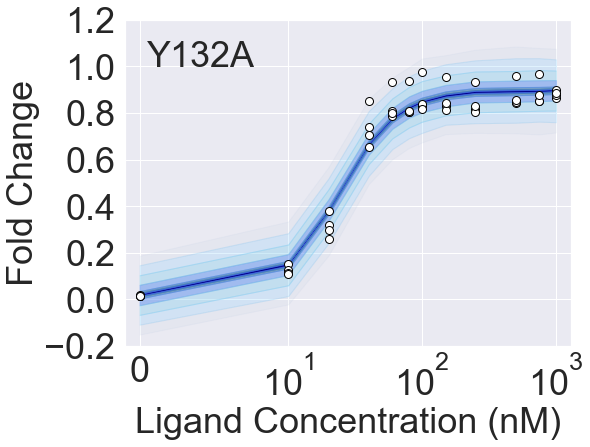

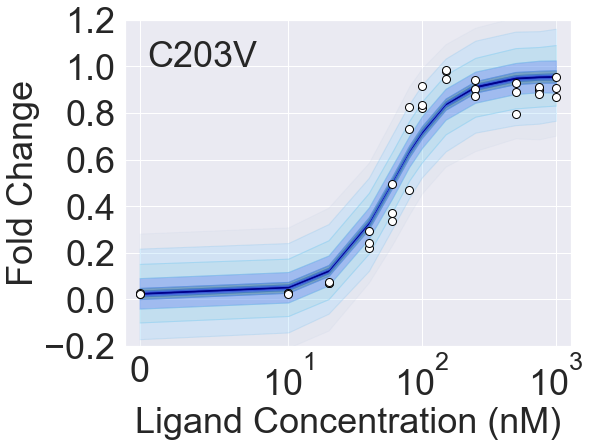

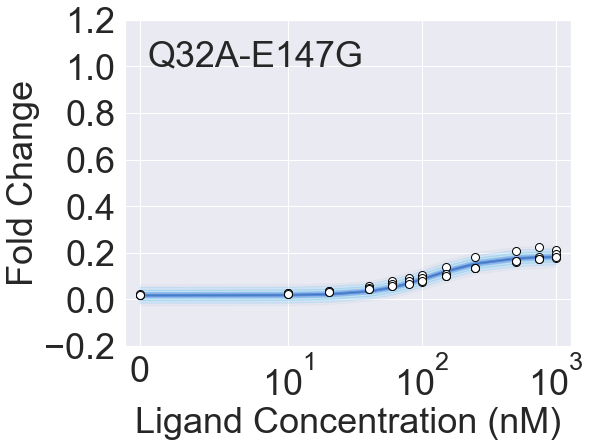

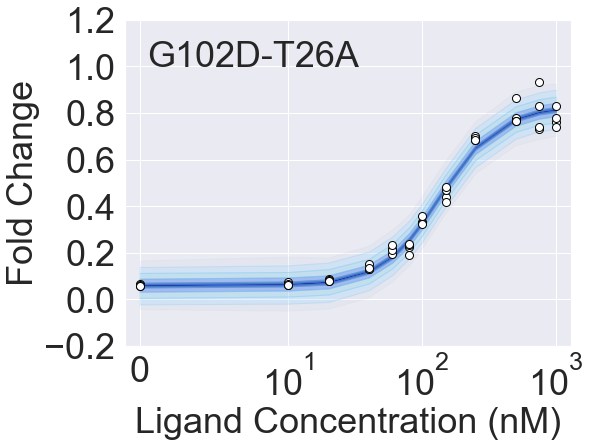

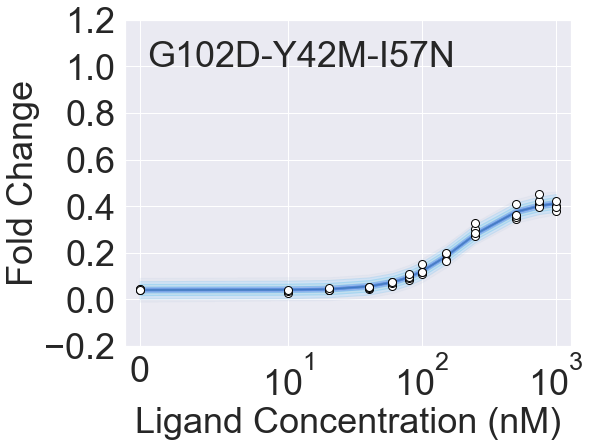

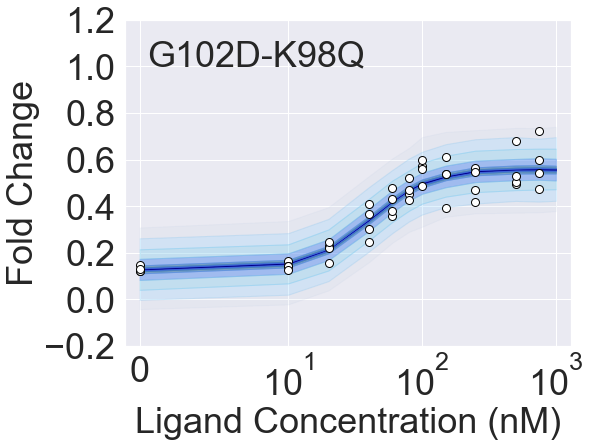

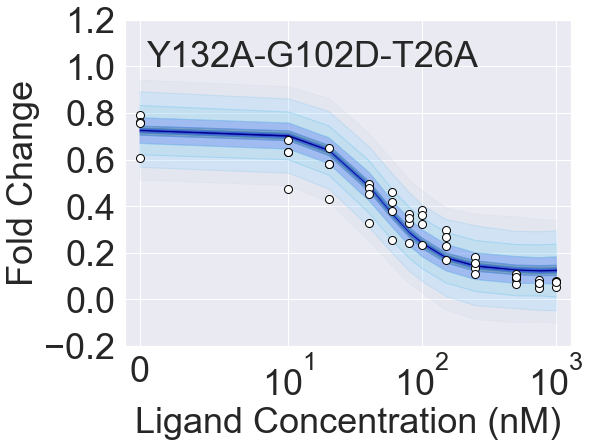

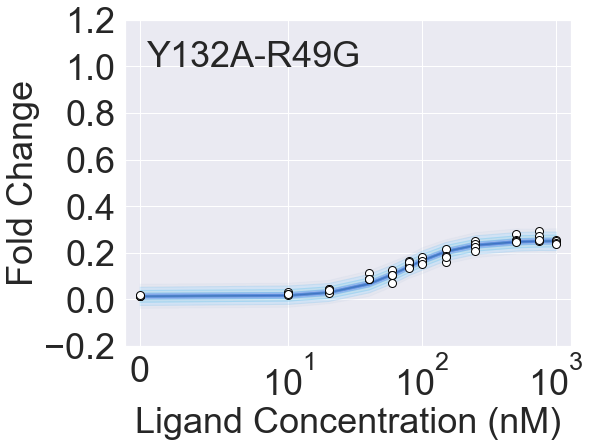

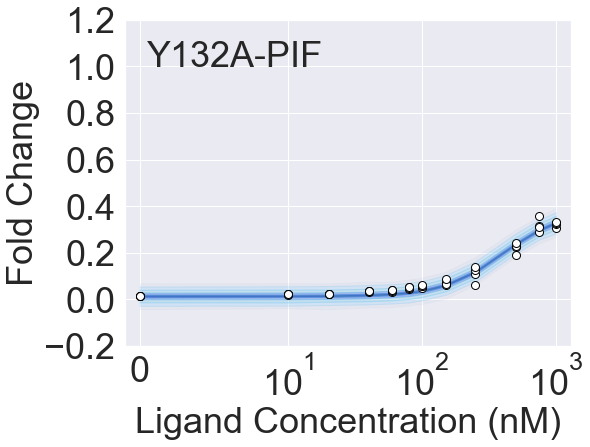

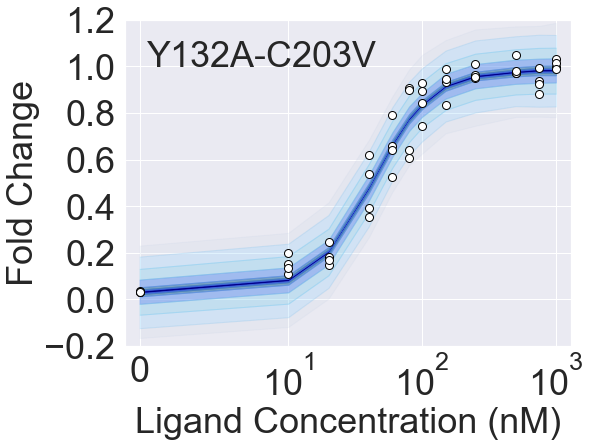

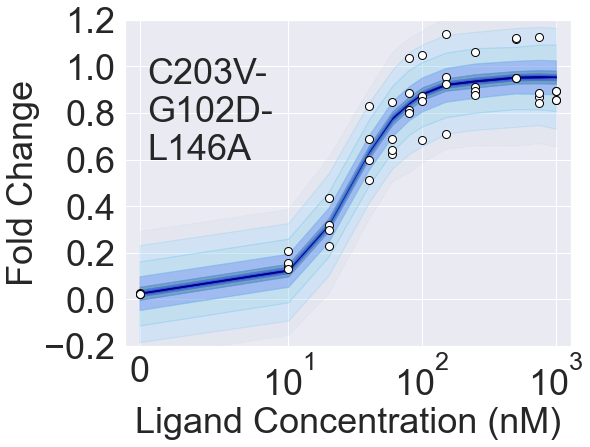

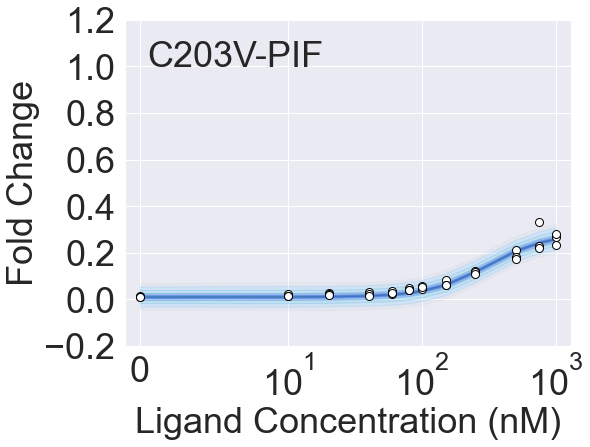

In [11]:
for i in range(23):
    if Post_mutname[i]=='Y132A': goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i],'Y132A')
        
for i in range(23):
    if Post_mutname[i]=='C203V': goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i][1:],'C203V')
        
for i in range(23):
    if Post_mutname[i]=='Q32A-E147G': 
        goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i],'Q32A-E147G')
        
for i in range(23):
    if Post_mutname[i]=='G102D-T26A': 
        goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i],'G102D-T26A')        

for i in range(23):
    if Post_mutname[i]=='G102D-Y42M-I57N': 
        goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i],'G102D-Y42M-I57N')       
        
for i in range(23):
    if Post_mutname[i]=='G102D-K98Q': 
        goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i],'G102D-K98Q')   
        
for i in range(23):
    if Post_mutname[i]=='G102D-L146A': 
        goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i],'G102D-L146A')  
        
        ''''combs'''
for i in range(23):
    if Post_mutname[i]=='Y132A-G102D-T26A': 
        goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i], 'Y132A-G102D-T26A')
        
for i in range(23):
    if Post_mutname[i]=='Y132A-R49G': 
        goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i], 'Y132A-R49G')
 
for i in range(23):
    if Post_mutname[i]=='Y132A-PIF': 
        goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i], 'Y132A-PIF')
    
for i in range(23):
    if Post_mutname[i]=='Y132A-C203V': 
        goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i], 'Y132A-C203V')
        
for i in range(23):
    if Post_mutname[i]=='C203V-G102D-L146A': 
        goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i], 'C203V-\nG102D-\nL146A')    
        
for i in range(23):
    if Post_mutname[i]=='C203V-PIF': 
        goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i][:-1], 'C203V-PIF')

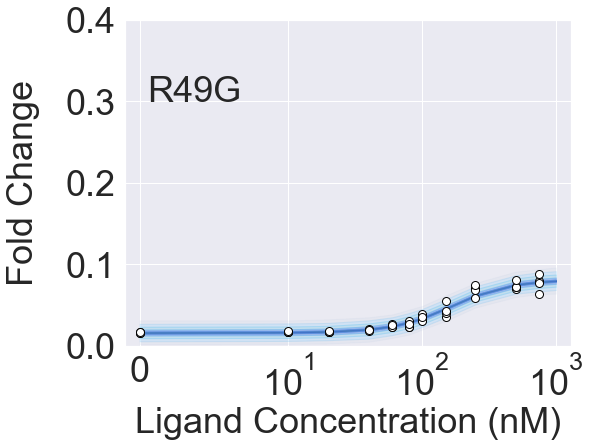

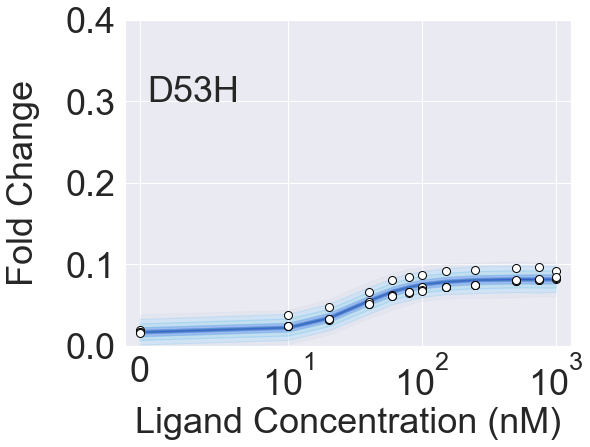

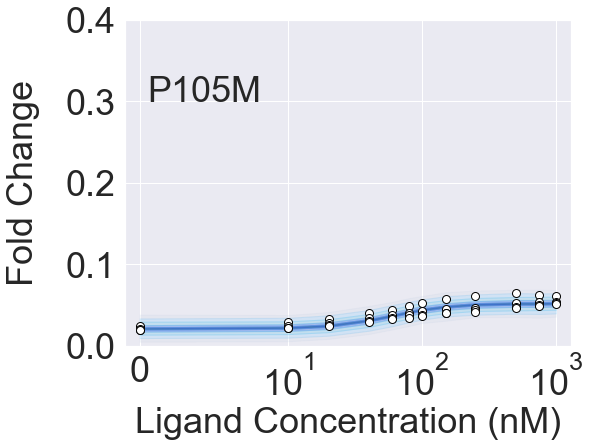

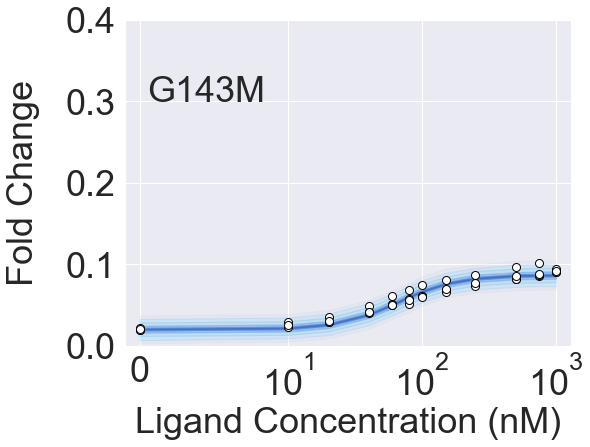

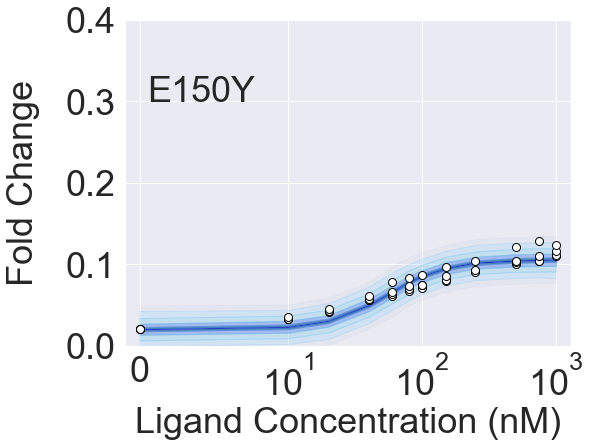

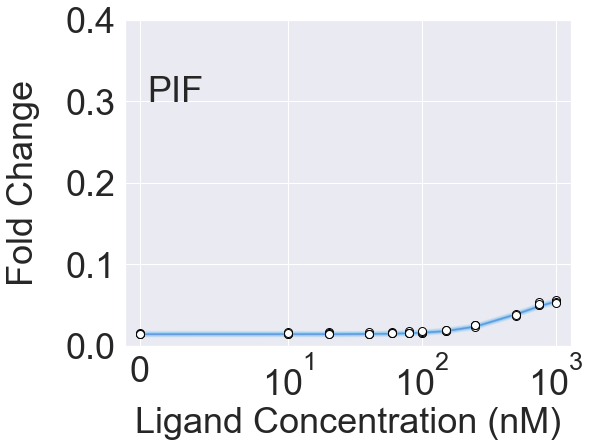

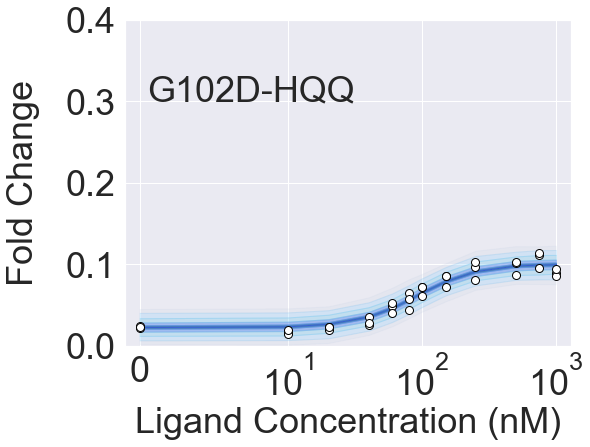

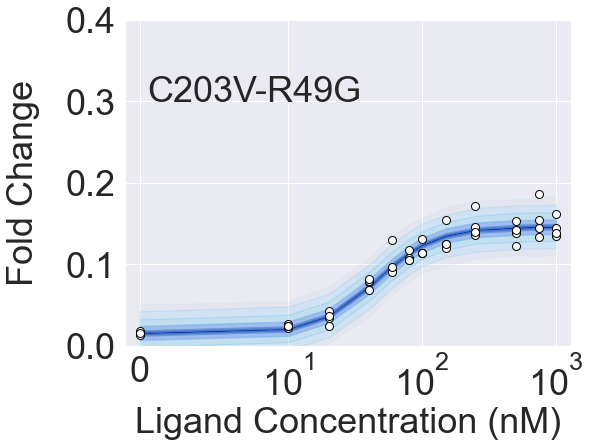

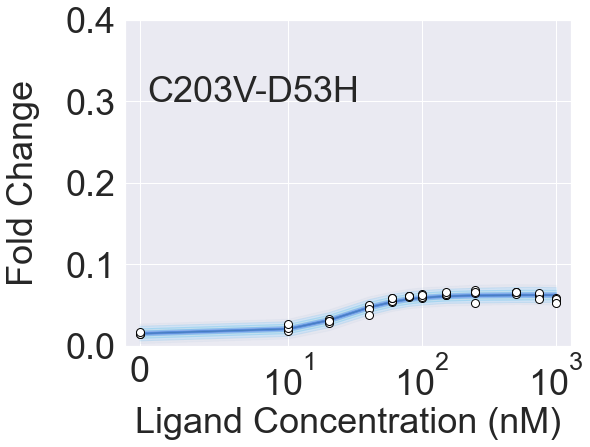

In [14]:
yticks_low=np.arange(0.0,0.41,0.1)
for i in range(23):
    if Post_mutname[i]=='R49G': 
        goodness_of_fit(Leakns_info[i][0], Post_Samples[i], np.asarray(FCs_read[i])[:,:-1],'R49G',0.2,0, yticks_low,True)

for i in range(23):
    if Post_mutname[i]=='D53H': 
            goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i],'D53H',0.2,0, yticks_low,True)
            
for i in range(23):
    if Post_mutname[i]=='P105M': 
            goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i],'P105M',0.2,0,  yticks_low,True)
            
for i in range(23):
    if Post_mutname[i]=='G143M': 
            goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i],'G143M',0.2,0,  yticks_low,True)
            
for i in range(23):
    if Post_mutname[i]=='E150Y': 
            goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i],'E150Y',0.2,0,  yticks_low,True)
            
for i in range(23):
    if Post_mutname[i]=='PIF': 
            goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i],'PIF',0.2,0,  yticks_low,True)

for i in range(23):
    if Post_mutname[i]=='G102D-HQQ': 
            goodness_of_fit(Leakns_info[i][0], Post_Samples[i], FCs_read[i][1:],'G102D-HQQ',0.2,0,  yticks_low,True)
                        
'''combs'''

for i in range(23):
    if Post_mutname[i]=='C203V-R49G': 
            goodness_of_fit(Leakns_info[i][0], Post_Samples[i],FCs_read[i],'C203V-R49G',0.2,0,  yticks_low,True)
            
for i in range(23):
    if Post_mutname[i]=='C203V-D53H': 
            goodness_of_fit(Leakns_info[i][0], Post_Samples[i],FCs_read[i],'C203V-D53H',0.2,0,  yticks_low,True)
                

In [15]:
def goodness_of_fitWT(lkns,paraminfered_mutant,DATA4,name,limyh=1.2,limyl=-0.2,yticks=np.arange(-0.2,1.21,0.2)):
    mc_step=len(paraminfered_mutant)
    Us=[] # 4001*12 4001 sets of params, 12 expectation for 12concentrations for each set of param
    for each in paraminfered_mutant:
        tempu=[]
        for c in C_ATC:
            tempu.append(fold_change(lkns,each[0],each[1],c))
        Us.append(tempu)
    np.shape(Us)
    ## for each set of params, generate 48 fold changes
    predict_fc=[]
    for i in range(mc_step):
        temp12=[]
        for j in range(12):
            temp=[]
            for k in range(12):
                temp.append(np.random.normal(Us[i][j],paraminfered_mutant[i][2]))
            temp12.append(temp)
        predict_fc.append(temp12)
    print(len(predict_fc))
    print(len(predict_fc[0]))
    print(len(predict_fc[0][0]))
    
    fc_predict_12=[]
    for m in range(12):
        tempm=[]
        for n in range(mc_step):
            for each in predict_fc[n][m]:
                tempm.append(each)
        fc_predict_12.append(np.sort(tempm))
    print(np.shape(fc_predict_12))
    
    # next, plot the predictive fold change from the infered 4001 sets of param
    fc_median=[]
    fc_up5,fc_low5=[],[]
    fc_up10,fc_low10=[],[]
    fc_up20,fc_low20=[],[]
    fc_up50,fc_low50=[],[]
    fc_up80,fc_low80=[],[]
    fc_up95,fc_low95=[],[]
    fc_up99,fc_low99=[],[]
    
    mc_step*=12
    print(mc_step)
    
    for i in range(12):
        fc_median.append(np.median(fc_predict_12[i]))
        fc_up5.append(fc_predict_12[i][round(mc_step*0.95/2)])
        fc_low5.append(fc_predict_12[i][-round(mc_step*0.95/2)])
        fc_up10.append(fc_predict_12[i][round(mc_step*0.9/2)])
        fc_low10.append(fc_predict_12[i][-round(mc_step*0.9/2)])
        fc_up20.append(fc_predict_12[i][round(mc_step*0.8/2)])
        fc_low20.append(fc_predict_12[i][-round(mc_step*0.8/2)])
        fc_up50.append(fc_predict_12[i][round(mc_step*0.5/2)])
        fc_low50.append(fc_predict_12[i][-round(mc_step*0.5/2)])
        fc_up80.append(fc_predict_12[i][round(mc_step*0.2/2)])
        fc_low80.append(fc_predict_12[i][-round(mc_step*0.2/2)])
        fc_up95.append(fc_predict_12[i][round(mc_step*0.05/2)])
        fc_low95.append(fc_predict_12[i][-round(mc_step*0.05/2)])
        fc_up99.append(fc_predict_12[i][round(mc_step*0.01/2)])
        fc_low99.append(fc_predict_12[i][-round(mc_step*0.01/2)])

    FC_pred_plot = plt.figure(figsize=(8,6))  # Fold-change predict plot
    fcpred = FC_pred_plot.add_subplot(1,1,1)
    color1,color2,color3,color4,color5,color6,color7 = 'darkblue','royalblue','steelblue','cornflowerblue','skyblue','lightskyblue','lightsteelblue'
    fcpred.fill_between(C_ATC, fc_up5, fc_low5, alpha=1,label='5',color=color1)
    fcpred.fill_between(C_ATC, fc_up10, fc_up5, alpha=.85,label='10',color=color2)
    fcpred.fill_between(C_ATC, fc_low5, fc_low10, alpha=.85,color=color2)
    fcpred.fill_between(C_ATC, fc_up20, fc_up10, alpha=.7,label='20',color=color3)
    fcpred.fill_between(C_ATC, fc_low10, fc_low20, alpha=.7,color=color3)
    fcpred.fill_between(C_ATC, fc_up50, fc_up20, alpha=.55,label='50',color=color4)
    fcpred.fill_between(C_ATC, fc_low20, fc_low50, alpha=.55,color=color4)
    fcpred.fill_between(C_ATC, fc_up80, fc_up50, alpha=.4,label='80',color=color5)
    fcpred.fill_between(C_ATC, fc_low50, fc_low80, alpha=.4,color=color5)
    fcpred.fill_between(C_ATC, fc_up95, fc_up80, alpha=.25,label='95',color=color6)
    fcpred.fill_between(C_ATC, fc_low80, fc_low95, alpha=.25,color=color6)
    fcpred.fill_between(C_ATC, fc_up99, fc_up95, alpha=.1,label='99',color=color7)
    fcpred.fill_between(C_ATC, fc_low95, fc_low99, alpha=.1,color=color7)

    fcpred.plot(C_ATC,DATA4[0],'o', mfc='white',mec='black',mew=1,markersize=8,label='data')
    for m in range(1,12):
        if m in [9,10]:
            fcpred.plot(C_ATC[:9]+[C_ATC[-1]],DATA4[m],'o', mfc='white',mec='black',mew=1,markersize=8)
        elif m==7:
            fcpred.plot(C_ATC[:10]+[C_ATC[-1]],DATA4[m],'o', mfc='white',mec='black',mew=1,markersize=8)     
        else:
            fcpred.plot(C_ATC[:len(DATA4[m])],DATA4[m],'o', mfc='white',mec='black',mew=1,markersize=8)
            
    fcpred.tick_params(labelsize=36) # make ticks bigger
    fcpred.set_ylim([limyl, limyh])
    fcpred.set_xlim([-1, 1300])
    fcpred.set_yticks(yticks)
    fcpred.set_ylabel('Fold Change', fontsize = 36)
    fcpred.set_xlabel('Ligand Concentration (nM)', fontsize = 36)
    
    l = fcpred.legend(bbox_to_anchor=(-0.02, 1.07), loc='upper left',handletextpad=0.2, columnspacing=0.5,handlelength=0.8,ncol=2,fontsize=36,title='percentile',frameon=False)
    title = l.get_title()
    title.set_fontsize(36)
    fcpred.text(400,1,name, fontsize=36)
    fcpred.set_xscale('symlog',linthresh=10)
#     FC_pred_plot.savefig('Figures/fits/{0:}_FC_fit'.format(name),dpi=300,bbox_inches='tight',pad_inches=0.01)
    

1000
12
12
(12, 12000)
12000


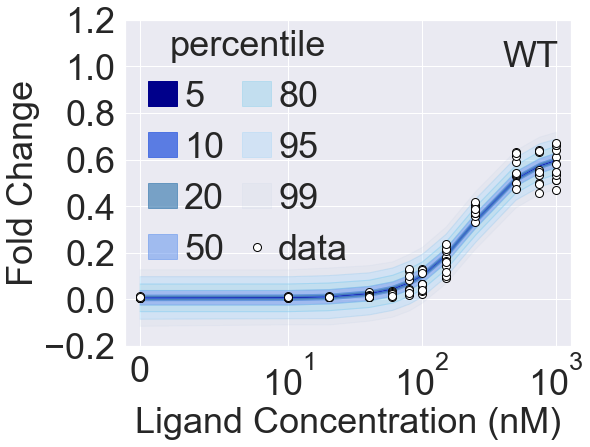

In [16]:
goodness_of_fitWT(Leakns_info[-1][0], Post_Samples[-1], FCs_read[-1],'WT')